<a href="https://colab.research.google.com/github/DeepLearningSaeid/Grad/blob/main/Optimized%20SWAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install autokeras -q





In [7]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects, to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris, load_digits, load_wine, load_diabetes, load_breast_cancer, fetch_olivetti_faces, load_linnerud
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.datasets import load_digits


In [8]:
# Define Custom Activation Functions:
# We create a function define_activation_functions to define a series of polynomial-based custom activation functions.

# Set random seed
np.random.seed(110)

# Define custom activation functions and update the custom objects dictionary
def define_activation_functions():
    """
    Define custom activation functions and update the custom objects dictionary.
    """
    # Define activation functions and their respective names
    activation_functions = [
        ('X_1', lambda x: tf.pow(x, 1)),
        ('X_2', lambda x: tf.pow(x, 2) / 2),
        ('X_2_', lambda x: tf.pow(x, 2) / 24),
        ('X_2__', lambda x: tf.pow(x, 2) / 720),
        ('X_2___', lambda x: tf.pow(x, 2) / 40320),
    ]

    # Update the custom objects dictionary with the defined activation functions
    for name, function in activation_functions:
        get_custom_objects().update({name: Activation(function)})

# Define and register the custom activation functions
define_activation_functions()

def create_optimized_model(input_dim, hidden_dim, output_dim, metrics='accuracy', learning_rate=0.001):
    """
    Create an optimized SWAG model with a custom architecture.

    :param input_dim: int, dimension of the input data
    :param output_dim: int, dimension of the output data
    :param hidden_dim: int, hidden layer dimension, default is 50
    :return: Model, a compiled Keras model
    """

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # First layer with custom activations
    layer_1_x1 = Dense(hidden_dim, activation='X_1')(input_layer)
    layer_1_x2 = Dense(hidden_dim, activation='X_2')(input_layer)
    concat_first_layer = concatenate([layer_1_x1, layer_1_x2])

    # Second layer with custom activations
    layer_x3_x4 = Dense(hidden_dim, activation='X_2_')(concat_first_layer)

    # Third layer with custom activations
    layer_x5_x6 = Dense(hidden_dim, activation='X_2__')(layer_x3_x4)

    # Concatenate all layers
    concat_second_layer = concatenate([layer_1_x1, layer_1_x2, concat_first_layer,
                                       layer_x3_x4, layer_x5_x6])

    # Output layer for the concatenated layers
    output_first_layer = Dense(hidden_dim, activation='linear')(concat_second_layer)

    # Final output layer
    output_layer = Dense(output_dim, activation='linear')(output_first_layer)

    # Create and compile the model
    model = Model(input_layer, output_layer)

    # Define the optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with specified loss and metrics
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=[metrics])

    return model



In [9]:


# Create an instance of the optimized model
# Input dimension is 784 (28x28 pixels, flattened),
# 500 hidden units in each layer,
# 10 output units (one for each digit)
optimized_model = create_optimized_model(784, 500, 10, 'accuracy')

# Load the MNIST dataset
# MNIST dataset contains 28x28 pixel grayscale images of handwritten digits (0-9)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
# Normalize the pixel values of the images by adding 10 and dividing by 300
# This changes the range of pixel values and can help with model training
x_train, x_test = (x_train + 10) / 300.0, (x_test + 10) / 300.0

# Reshape the data
# Flatten the 28x28 images into 1D arrays of 784 elements for model input
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# One-hot encode the labels
# Convert class vectors (integers) to binary class matrices for use with categorical crossentropy
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Training the model
# Specify batch size and number of epochs for training
batch_size = 100
epochs = 2

# Start a timer to measure training time
start = timeit.default_timer()

# Fit the model on the training data
# x_train and y_train are the training data and labels
# Batch size determines the number of samples processed before the model is updated
# Epochs is the number of complete passes through the training dataset
# Verbose=1 shows a progress bar during training
# Validation data is used to evaluate the loss and any model metrics at the end of each epoch
history = optimized_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

# Stop the timer
end = timeit.default_timer()

# Output the training time
# Print the time taken by the training process
print(f"Training time: {end - start} seconds")


Epoch 1/2
600/600 [==============================] - 29s 45ms/step - loss: 0.0427 - accuracy: 0.8382 - val_loss: 0.0267 - val_accuracy: 0.9042
Epoch 2/2
171/600 [=======>......................] - ETA: 15s - loss: 0.0227 - accuracy: 0.9309

KeyboardInterrupt: 

In [ ]:


# Load the Fashion MNIST dataset
# Fashion MNIST is a dataset of Zalando's article images, consisting of 60,000 training and 10,000 test examples.
# Each example is a 28x28 grayscale image, associated with a label from 10 classes.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
# Normalize the pixel values of the images by adding 10 and then dividing by 300.
# This changes the range of pixel values and can help with model training.
x_train, x_test = (x_train + 10) / 300.0, (x_test + 10) / 300.0

# Reshape the data
# Flatten the 28x28 images into 1D arrays of 784 elements for model input.
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# One-hot encode the labels
# Convert class vectors (integers) to binary class matrices for use with categorical crossentropy.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define training parameters
batch_size = 100
epochs = 5

# # AutoKeras model
# # AutoKeras is an AutoML system based on Keras. It tries different model architectures automatically.
# # Here, StructuredDataClassifier is used, suitable for structured data classification.
# # max_trials parameter indicates how many different models to try.
# ak_model = ak.StructuredDataClassifier(max_trials=3, overwrite=True)

# # Start a timer for the AutoKeras model training
# start_ak = timeit.default_timer()

# # Fit the AutoKeras model on the training data
# ak_model.fit(x_train, y_train, epochs=10)

# # Stop the timer and print the training time
# end_ak = timeit.default_timer()
# print(f"AutoKeras Training time: {end_ak - start_ak} seconds")

# # Evaluate the AutoKeras model
# # The evaluate function returns the loss value & metrics values for the model in test mode.
# _, ak_accuracy = ak_model.evaluate(x_test, y_test)
# print(f"AutoKeras Model Accuracy: {ak_accuracy}")

# # Print separator for clarity in output
print('******************************************************************************************')

# Custom optimized model
# Create an instance of a custom optimized model with specific parameters.
optimized_model = create_optimized_model(784, 500, 10, 'accuracy')

# Start a timer for the custom model training
start = timeit.default_timer()

# Fit the custom model on the training data
history = optimized_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

# Stop the timer and print the training time
end = timeit.default_timer()
print(f"Training time: {end - start} seconds")


In [ ]:


# Load the Iris dataset
# The Iris dataset is a classic dataset for classification, containing 3 types of Iris flowers
iris = load_iris()
X = iris.data  # Feature matrix (measurements of the flowers)
y = iris.target  # Target vector (types of Iris flowers)

# Split the dataset into training and testing sets
# 80% of data is used for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
# StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit to data and then transform it
X_test = scaler.transform(X_test)        # Perform standardization by centering and scaling

# One-hot encode the labels
# Convert class vectors (integers) to binary class matrices
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

# Determine the number of features and classes
num_features = X_train.shape[1]  # Number of features
num_classes = y_train.shape[1]   # Number of classes

# AutoKeras model
# AutoKeras is an AutoML system based on Keras. It automatically tries different model architectures.
# max_trials is the number of different models to try.
ak_model = ak.StructuredDataClassifier(max_trials=3, overwrite=True)

# Start timing the AutoKeras training
start_ak = timeit.default_timer()

# Train the AutoKeras model
ak_model.fit(X_train, y_train, epochs=10)

# Stop timing and print the training duration
end_ak = timeit.default_timer()
print(f"AutoKeras Training time: {end_ak - start_ak} seconds")

# Evaluate the AutoKeras model
# Evaluates the model on the testing dataset
_, ak_accuracy = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model Accuracy: {ak_accuracy}")

# Print separators for output clarity
print('******************************************************************************************')

# Custom model
# Create an instance of a custom optimized model with specific parameters
model = create_optimized_model(num_features, 10, num_classes, 'accuracy')

# Training parameters
batch_size = 10
epochs = 10

# Start timing the custom model training
start = timeit.default_timer()

# Train the custom model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

# Stop timing and print the training duration
end = timeit.default_timer()
print(f"Training time: {end - start} seconds")

# Evaluate the custom model
# Evaluates the model on the testing dataset
_, accuracy = model.evaluate(X_test, y_test)
print(f"SWAG Model Accuracy: {accuracy}")


Trial 3 Complete [00h 00m 04s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.9583333134651184
Total elapsed time: 00h 00m 12s
Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 1.0156 - accuracy: 0.3333
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.9557 - accuracy: 0.4250
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8991 - accuracy: 0.5833
Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8462 - accuracy: 0.7083
Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7965 - accuracy: 0.7667
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7503 - accuracy: 0.7833
Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.8083
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.8083
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.8083
Epoch 1

In [ ]:


# Load and preprocess the dataset
# The 'digits' dataset is a collection of 8x8 pixel images of handwritten digits
digits = load_digits()
X = digits.data  # Feature matrix (pixel values of images)
y = to_categorical(digits.target)  # One-hot encode the target labels

# Splitting the dataset into training and testing sets
# 80% of data is used for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using MinMaxScaler to scale the data
# MinMaxScaler scales each feature to a given range, here between 0 and 1.
# This is important for neural network models which are sensitive to input scale.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit to data, then transform it
X_test = scaler.transform(X_test)        # Apply the same transformation to the test data

# Determine the number of features and classes from the data
num_features = X_train.shape[1]  # Number of features (64 pixels per image in this case)
num_classes = y_train.shape[1]   # Number of classes (digits 0-9, so 10 classes)

# Print the number of features for confirmation
print(num_features)

# AutoKeras model
# AutoKeras is an AutoML system based on Keras, automating the process of model selection and training.
# max_trials indicates how many different models to try.
ak_model = ak.StructuredDataClassifier(max_trials=5, overwrite=True)

# Define the number of epochs for training
epochs = 5

# Train the AutoKeras model
# Fit the model to the training data
ak_model.fit(X_train, y_train, epochs=epochs)

# Evaluate the AutoKeras model on the test set
# Evaluates the model's performance in terms of loss and accuracy
loss, ak_accuracy = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model Accuracy: {ak_accuracy}")

# Print separator for clarity in output
print('******************************************************************************************')

# Custom optimized model
# Creating an instance of a custom optimized model with specific parameters
model = create_optimized_model(num_features, 200, num_classes, 'accuracy')

# Training parameters for the custom model
batch_size = 10  # Number of samples per gradient update

# Train the custom model
# Fit the model to the training data using defined batch size and epochs
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the custom model on the test set
# Evaluates the model's performance in terms of loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"SWAG Accuracy: {accuracy}")


Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.7684210538864136

Best val_accuracy So Far: 0.8105263113975525
Total elapsed time: 00h 01m 30s
Epoch 1/5
45/45 [==============================] - 2s 4ms/step - loss: 1.8918 - accuracy: 0.4210
Epoch 2/5
45/45 [==============================] - 0s 4ms/step - loss: 1.0654 - accuracy: 0.6875
Epoch 3/5
45/45 [==============================] - 0s 4ms/step - loss: 0.7065 - accuracy: 0.7815
Epoch 4/5
45/45 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.8288
Epoch 5/5
12/12 [==============================] - 1s 4ms/step - loss: 0.5038 - accuracy: 0.8472
AutoKeras Model Accuracy: 0.8472222089767456
******************************************************************************************
Epoch 1/5
144/144 [==============================] - 2s 5ms/step - loss: 0.0556 - accuracy: 0.8323
Epoch 2/5
144/144 [==============================] - 1s 5ms/step - loss: 0.0233 - accuracy: 0.9631
Epoch 3/5
144/144 [====================

In [ ]:


# Load and preprocess the dataset
# The Wine dataset is a classic multiclass classification dataset
wine = load_wine()
X = wine.data  # Feature matrix (chemical constituents of wines)
y = to_categorical(wine.target)  # One-hot encode the target labels

# Splitting the dataset into training and testing sets
# 80% of data is used for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using MinMaxScaler to scale the data
# MinMaxScaler scales each feature to a given range, here between 0 and 1
# This is important for neural network models which are sensitive to input scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit to data, then transform it
X_test = scaler.transform(X_test)        # Apply the same transformation to the test data

# Determine the number of features and classes from the data
num_features = X_train.shape[1]  # Number of features
num_classes = y_train.shape[1]   # Number of classes

# Print the number of features for confirmation
print(num_features)

# Define training parameters
batch_size = 10
epochs = 5

# AutoKeras model
# AutoKeras is an AutoML system based on Keras, automating the process of model selection and training
# max_trials indicates how many different models to try
ak_model = ak.StructuredDataClassifier(max_trials=5, overwrite=True)

# Train the AutoKeras model
# Fit the model to the training data
ak_model.fit(X_train, y_train, epochs=epochs)

# Evaluate the AutoKeras model on the test set
# Evaluates the model's performance in terms of loss and accuracy
loss, ak_accuracy = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model Accuracy: {ak_accuracy}")

# Print separators for clarity in output
print('******************************************************************************************')

# Custom optimized model
# Creating an instance of a custom optimized model with specific parameters
model = create_optimized_model(num_features, 20, num_classes, 'accuracy')

# Train the custom model
# Fit the model to the training data using defined batch size and epochs
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the custom model on the test set
# Evaluates the model's performance in terms of loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"SWAG Accuracy: {accuracy}")


Trial 5 Complete [00h 00m 03s]
val_accuracy: 0.5714285969734192

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 23s
Epoch 1/5
5/5 [==============================] - 1s 4ms/step - loss: 1.0299 - accuracy: 0.3873
Epoch 2/5
5/5 [==============================] - 0s 3ms/step - loss: 0.9343 - accuracy: 0.5141
Epoch 3/5
5/5 [==============================] - 0s 3ms/step - loss: 0.8535 - accuracy: 0.6127
Epoch 4/5
5/5 [==============================] - 0s 3ms/step - loss: 0.7816 - accuracy: 0.6972
Epoch 5/5
2/2 [==============================] - 0s 8ms/step - loss: 0.7065 - accuracy: 0.7778
AutoKeras Model Accuracy: 0.7777777910232544
******************************************************************************************
Epoch 1/5
15/15 [==============================] - 1s 2ms/step - loss: 0.3226 - accuracy: 0.3380
Epoch 2/5
15/15 [==============================] - 0s 3ms/step - loss: 0.1859 - accuracy: 0.5563
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - los

In [ ]:


# Load and preprocess the dataset
# The Breast Cancer dataset is a binary classification dataset
cancer = load_breast_cancer()
X = cancer.data  # Feature matrix (characteristics of the cell nuclei)
y = cancer.target  # Target vector (cancer diagnosis: malignant or benign)

# Splitting the dataset into training and testing sets
# 80% of data is used for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using MinMaxScaler to scale the data
# MinMaxScaler scales each feature to a given range, here between 0 and 1
# This is important for neural network models which are sensitive to input scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit to data, then transform it
X_test = scaler.transform(X_test)        # Apply the same transformation to the test data

# Determine the number of features from the data
num_features = X_train.shape[1]  # Number of features

# Print the number of features for confirmation
print(num_features)

# Define training parameters
batch_size = 10
epochs = 5

# AutoKeras model
# AutoKeras is an AutoML system based on Keras, automating the process of model selection and training
# max_trials indicates how many different models to try
ak_model = ak.StructuredDataClassifier(max_trials=5, overwrite=True)

# Train the AutoKeras model
# Fit the model to the training data
ak_model.fit(X_train, y_train, epochs=epochs)

# Evaluate the AutoKeras model on the test set
# Evaluates the model's performance in terms of loss and accuracy
loss, ak_accuracy = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model Accuracy: {ak_accuracy}")

# Print separators for clarity in output
print('******************************************************************************************')

# Custom optimized model
# Creating an instance of a custom optimized model with specific parameters
# Here, the output layer has 1 unit because it's a binary classification problem
model = create_optimized_model(num_features, 20, 1, 'accuracy')

# Train the custom model
# Fit the model to the training data using defined batch size and epochs
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the custom model on the test set
# Evaluates the model's performance in terms of loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")


Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.9577465057373047

Best val_accuracy So Far: 0.9718309640884399
Total elapsed time: 00h 00m 21s
Epoch 1/5
15/15 [==============================] - 3s 6ms/step - loss: 0.3575 - accuracy: 0.8637
Epoch 2/5
15/15 [==============================] - 0s 5ms/step - loss: 0.2153 - accuracy: 0.9341
Epoch 3/5
15/15 [==============================] - 0s 5ms/step - loss: 0.1774 - accuracy: 0.9385
Epoch 4/5
15/15 [==============================] - 0s 5ms/step - loss: 0.1526 - accuracy: 0.9451
Epoch 5/5
4/4 [==============================] - 0s 6ms/step - loss: 0.3579 - accuracy: 0.9649
AutoKeras Model Accuracy: 0.9649122953414917
******************************************************************************************
Epoch 1/5
46/46 [==============================] - 1s 2ms/step - loss: 0.2616 - accuracy: 0.6022
Epoch 2/5
46/46 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.8571
Epoch 3/5
46/46 [============================

In [ ]:
import timeit
import autokeras as ak
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load Boston Housing data
# The Boston Housing dataset contains information about various houses in Boston
# It's used for regression tasks to predict the value of houses based on different attributes
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)

# Using MinMaxScaler to scale the data
# MinMaxScaler scales each feature to a given range, here between 0 and 1
# This scaling can improve the performance of neural network models
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit to data, then transform it
X_test = scaler.transform(X_test)        # Apply the same transformation to the test data

# Define training parameters
batch_size = 5
epochs = 30

# AutoKeras model for regression
# AutoKeras StructuredDataRegressor automatically tries different model architectures
# max_trials indicates how many different models to try
ak_model = ak.StructuredDataRegressor(max_trials=3, overwrite=True)

# Start timing the AutoKeras model training
start_ak = timeit.default_timer()

# Train the AutoKeras model
ak_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Stop timing and print the training duration
end_ak = timeit.default_timer()
print(f"AutoKeras Training time: {end_ak - start_ak} seconds")

# Evaluate the AutoKeras model
# Evaluates the model's performance in terms of loss and mean absolute error (MAE)
loss, ak_mae = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model MAE: {ak_mae}")

# Print separators for output clarity
print('******************************************************************************************')

# Custom optimized model for regression
# Create an instance of a custom optimized model with specific parameters
# The model is designed for regression with Mean Absolute Error (MAE) as the metric
input_dim = X_train.shape[1]  # Number of input features
optimized_model = create_optimized_model(input_dim, input_dim, 1, 'mae')  # Using input_dim as hidden_dim and 1 output unit

# Start timing the custom model training
start = timeit.default_timer()

# Train the custom model
# Fit the model to the training data using defined batch size and epochs
history = optimized_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

# Stop timing and print the training duration
end = timeit.default_timer()
print(f"Training time: {end - start} seconds")
# Evaluate the AutoKeras model
# Evaluates the model's performance in terms of loss and mean absolute error (MAE)
loss, _mae = optimized_model.evaluate(X_test, y_test)
print(f"AutoKeras Model MAE: {_mae}")

# Print separators for output clarity


Trial 3 Complete [00h 00m 14s]
val_loss: 16.00876808166504

Best val_loss So Far: 13.422754287719727
Total elapsed time: 00h 00m 36s
Epoch 1/30
81/81 [==============================] - 1s 2ms/step - loss: 524.3591 - mean_squared_error: 524.3591
Epoch 2/30
81/81 [==============================] - 0s 2ms/step - loss: 253.2520 - mean_squared_error: 253.2520
Epoch 3/30
81/81 [==============================] - 0s 2ms/step - loss: 56.7244 - mean_squared_error: 56.7244
Epoch 4/30
81/81 [==============================] - 0s 2ms/step - loss: 27.7045 - mean_squared_error: 27.7045
Epoch 5/30
81/81 [==============================] - 0s 2ms/step - loss: 21.3050 - mean_squared_error: 21.3050
Epoch 6/30
81/81 [==============================] - 0s 2ms/step - loss: 19.5173 - mean_squared_error: 19.5173
Epoch 7/30
81/81 [==============================] - 0s 2ms/step - loss: 18.4249 - mean_squared_error: 18.4249
Epoch 8/30
81/81 [==============================] - 0s 2ms/step - loss: 17.5090 - mean_square

In [ ]:


# Load the dataset
# The Diabetes dataset is commonly used for regression analysis
diabetes = load_diabetes()
X = diabetes.data  # Feature matrix (medical measurements)
y = diabetes.target  # Target variable (quantitative measure of disease progression)

# Split the dataset into training and testing sets
# test_size=0.2 allocates 20% of the data for testing and the rest for training
# random_state=42 ensures reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
# MinMaxScaler scales each feature to a range between 0 and 1
# This scaling is beneficial for neural network models
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit to the training data and transform it
X_test = scaler.transform(X_test)        # Transform the test data using the same scale

# Determine the number of features from the data
num_features = X_train.shape[1]  # Number of features in the dataset
print(num_features)

# Define training parameters
batch_size = 10
epochs = 30

# AutoKeras StructuredDataRegressor model
# This is an AutoML model that automatically searches for the best model architecture
# max_trials=3 sets the number of different models AutoKeras will try
ak_model = ak.StructuredDataRegressor(max_trials=3, overwrite=True)

# Train the AutoKeras model
# Fit the model on the training data
ak_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the AutoKeras model
# Evaluates the model's performance in terms of loss and mean absolute error (MAE)
loss_ak, ak_mae = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model MAE: {ak_mae}")

# Print separators for clarity in output
print('******************************************************************************************')

# Custom optimized model
# Create an instance of a custom optimized model for regression
# This model uses the mean absolute error (MAE) as a performance metric
model = create_optimized_model(num_features, 20, 1, 'mae')  # The model predicts a single output

# Train the custom model
# Fit the model on the training data
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the custom model
# Evaluates the model's performance in terms of loss and MAE
loss, mae = model.evaluate(X_test, y_test)
print(f"SWAG Model MAE: {mae}")


Trial 3 Complete [00h 00m 10s]
val_loss: 2850.165771484375

Best val_loss So Far: 2850.165771484375
Total elapsed time: 00h 00m 26s
Epoch 1/30
36/36 [==============================] - 1s 2ms/step - loss: 29247.7910 - mean_squared_error: 29247.7910
Epoch 2/30
36/36 [==============================] - 0s 2ms/step - loss: 27681.0391 - mean_squared_error: 27681.0391
Epoch 3/30
36/36 [==============================] - 0s 2ms/step - loss: 23830.2070 - mean_squared_error: 23830.2070
Epoch 4/30
36/36 [==============================] - 0s 2ms/step - loss: 16874.4863 - mean_squared_error: 16874.4863
Epoch 5/30
36/36 [==============================] - 0s 2ms/step - loss: 9236.7383 - mean_squared_error: 9236.7383
Epoch 6/30
36/36 [==============================] - 0s 2ms/step - loss: 5420.9854 - mean_squared_error: 5420.9854
Epoch 7/30
36/36 [==============================] - 0s 2ms/step - loss: 4483.4556 - mean_squared_error: 4483.4556
Epoch 8/30
36/36 [==============================] - 0s 2ms/ste

In [ ]:


# Load and preprocess the dataset
# The Olivetti Faces dataset contains a set of face images
faces = fetch_olivetti_faces()

X = faces.images  # Images of faces
y = to_categorical(faces.target)  # One-hot encode the target labels

# Split the dataset into training and testing sets
# test_size=0.2 allocates 20% of the data for testing, rest for training
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the image data to flatten the image arrays (64x64 pixels)
X_train = X_train.reshape((-1, 64*64))
X_test = X_test.reshape((-1, 64*64))

# Initialize a MinMaxScaler
# This scales each feature to a given range, here between 0.01 and 0.99
# Scaling images can improve the performance of neural network models
min_max_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

# Fit and transform the training data using the scaler
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = min_max_scaler.transform(X_test)

# Determine the number of features and classes from the data
num_features = X_train.shape[1]  # Number of features (flattened image size)
num_classes = y.shape[1]         # Number of classes (distinct faces)

# Print the number of classes for confirmation
print(num_classes)

# Define training parameters
batch_size = 10
epochs = 15

# AutoKeras model for classification
# AutoKeras StructuredDataClassifier automatically tries different model architectures
# max_trials=5 sets the number of different models AutoKeras will try
ak_model = ak.StructuredDataClassifier(max_trials=5, overwrite=True)

# Train the AutoKeras model
# Fit the model on the training data
ak_model.fit(X_train, y_train, epochs=epochs)

# Evaluate the AutoKeras model
# Evaluates the model's performance in terms of loss and accuracy
loss, ak_accuracy = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model Accuracy: {ak_accuracy}")

# Print separators for clarity in output
print('******************************************************************************************')

# Custom optimized model for classification
# Creating an instance of a custom optimized model with specific parameters
# The model uses accuracy as the performance metric
model = create_optimized_model(num_features, 600, num_classes, 'accuracy', 0.0001)  # Learning rate is set to 0.0001

# Train the custom model
# Fit the model on the training data using defined batch size and epochs
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the custom model
# Evaluates the model's performance in terms of loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"SWAG Model Accuracy: {accuracy}")


Trial 5 Complete [00h 02m 26s]
val_accuracy: 0.90625

Best val_accuracy So Far: 0.921875
Total elapsed time: 00h 12m 15s
Epoch 1/15
10/10 [==============================] - 56s 33ms/step - loss: 3.5355 - accuracy: 0.1344
Epoch 2/15
10/10 [==============================] - 0s 32ms/step - loss: 1.9764 - accuracy: 0.4281
Epoch 3/15
10/10 [==============================] - 0s 35ms/step - loss: 1.2810 - accuracy: 0.6156
Epoch 4/15
10/10 [==============================] - 0s 37ms/step - loss: 0.9327 - accuracy: 0.7156
Epoch 5/15
10/10 [==============================] - 0s 34ms/step - loss: 0.6149 - accuracy: 0.8594
Epoch 6/15
10/10 [==============================] - 0s 51ms/step - loss: 0.5160 - accuracy: 0.8813
Epoch 7/15
10/10 [==============================] - 1s 65ms/step - loss: 0.3889 - accuracy: 0.9000
Epoch 8/15
10/10 [==============================] - 1s 63ms/step - loss: 0.3358 - accuracy: 0.9156
Epoch 9/15
10/10 [==============================] - 1s 64ms/step - loss: 0.3205 - accu

In [ ]:


# Load and preprocess the Linnerud dataset
# The Linnerud dataset is a multivariate dataset containing physical measurements and exercise data
linnerud = load_linnerud()
X = linnerud.data  # Physical measurements (independent variables)
y = linnerud.target  # Exercise data (dependent variables)

# Split the dataset into training and testing sets
# test_size=0.2 allocates 20% of the data for testing and the rest for training
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using MinMaxScaler to scale the data
# MinMaxScaler scales each feature to a given range, here between 0 and 1
# This scaling can improve the performance of neural network models
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit to the training data and transform it
X_test = scaler.transform(X_test)        # Transform the test data using the same scale

# Determine the number of features from the data
num_features = X_train.shape[1]  # Number of features in the dataset
print(num_features)

# Define training parameters
batch_size = 10
epochs = 30

# AutoKeras StructuredDataRegressor model
# This is an AutoML model that automatically searches for the best model architecture
# max_trials=3 sets the number of different models AutoKeras will try
ak_model = ak.StructuredDataRegressor(max_trials=3, overwrite=True)

# Train the AutoKeras model
# Fit the model on the training data
ak_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the AutoKeras model
# Evaluates the model's performance in terms of loss and mean absolute error (MAE)
loss_ak, ak_mae = ak_model.evaluate(X_test, y_test)
print(f"AutoKeras Model MAE: {ak_mae}")

# Custom optimized model for regression
# Creating an instance of a custom optimized model with specific parameters
# This model uses mean absolute error (MAE) as a performance metric
model = create_optimized_model(num_features, 20, 1, 'mae')  # The model predicts a single output

# Train the custom model
# Fit the model on the training data using defined batch size and epochs
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the custom model
# Evaluates the model's performance in terms of loss and MAE
loss, mae = model.evaluate(X_test, y_test)
print(f"SWAG Model MAE: {mae}")


Trial 3 Complete [00h 00m 06s]
val_loss: 12321.6513671875

Best val_loss So Far: 12223.953125
Total elapsed time: 00h 00m 19s
Epoch 1/30
2/2 [==============================] - 1s 11ms/step - loss: 12131.4863 - mean_squared_error: 12131.4863
Epoch 2/30
2/2 [==============================] - 0s 7ms/step - loss: 12122.8203 - mean_squared_error: 12122.8203
Epoch 3/30
2/2 [==============================] - 0s 6ms/step - loss: 12114.1611 - mean_squared_error: 12114.1611
Epoch 4/30
2/2 [==============================] - 0s 6ms/step - loss: 12105.2480 - mean_squared_error: 12105.2480
Epoch 5/30
2/2 [==============================] - 0s 9ms/step - loss: 12096.0723 - mean_squared_error: 12096.0723
Epoch 6/30
2/2 [==============================] - 0s 7ms/step - loss: 12086.7188 - mean_squared_error: 12086.7188
Epoch 7/30
2/2 [==============================] - 0s 6ms/step - loss: 12077.1738 - mean_squared_error: 12077.1738
Epoch 8/30
2/2 [==============================] - 0s 6ms/step - loss: 12067

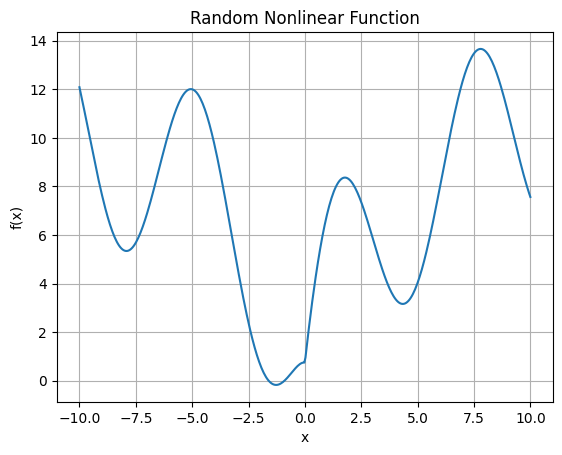

In [ ]:
import numpy as np
import random

def generate_random_nonlinear_function():
    """
    Generate a random nonlinear function based on a mix of sine, cosine, exponential,
    and logarithmic operations.
    """
    operations = [np.sin, np.cos, np.log]
    coeffs = np.random.uniform(-1, 5, 4)  # Random coefficients

    def random_function(x):
        result = 0
        for coeff, operation in zip(coeffs, operations):
            # Safeguard for the logarithmic function to avoid log(0) and negative values
            if operation == np.log:
                result += coeff * operation(np.abs(x) + 1)
            else:
                result += coeff * operation(x)
        return result

    return random_function

# Generate a random nonlinear function
random_func = generate_random_nonlinear_function()

# Test the function
x_values = np.linspace(-10, 10, 400)  # Generate 400 points between -10 and 10
y_values = random_func(x_values)

# You can plot this function using matplotlib to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.title("Random Nonlinear Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()


Trial 3 Complete [00h 00m 07s]
val_loss: 2.5610268115997314

Best val_loss So Far: 2.5610268115997314
Total elapsed time: 00h 00m 22s
Epoch 1/10
80/80 [==============================] - 1s 2ms/step - loss: 39.6040 - mean_squared_error: 39.6040
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 9.6967 - mean_squared_error: 9.6967
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 4.1334 - mean_squared_error: 4.1334
Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 3.6994 - mean_squared_error: 3.6994
Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 3.4861 - mean_squared_error: 3.4861
Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 3.5774 - mean_squared_error: 3.5774
Epoch 7/10
80/80 [==============================] - 0s 2ms/step - loss: 3.7364 - mean_squared_error: 3.7364
Epoch 8/10
80/80 [==============================] - 0s 2ms/step - loss: 3.5014 - mean_squared_error: 3.5014


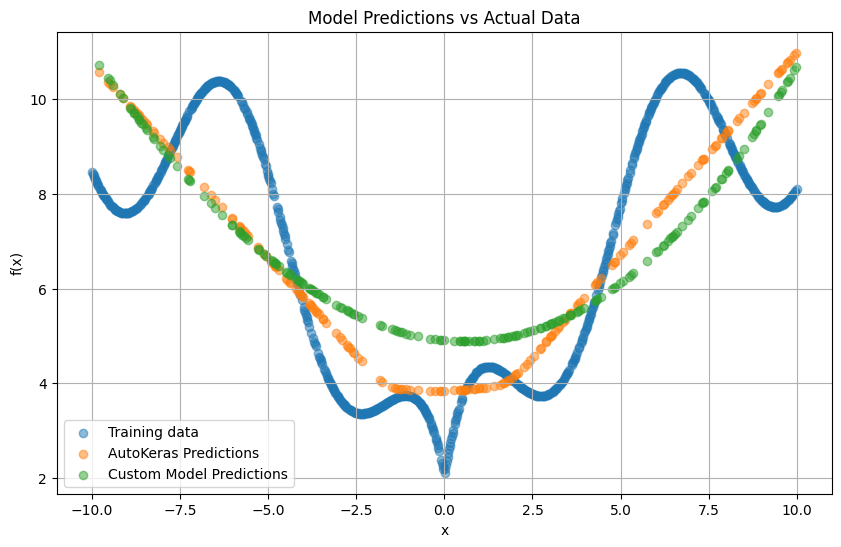

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import autokeras as ak
# from your_module import generate_random_nonlinear_function, create_optimized_model

# Generate the dataset
random_func = generate_random_nonlinear_function()  # Define this function
x_values = np.linspace(-10, 10, 1000)
y_values = random_func(x_values)
x_values = x_values.reshape(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=42)

scaler = MinMaxScaler(feature_range=(0.01, 0.99))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# AutoKeras Model
ak_model = ak.StructuredDataRegressor(max_trials=3, overwrite=True)
ak_model.fit(X_train_scaled, y_train, epochs=10, batch_size=10)
loss_ak, ak_mae = ak_model.evaluate(X_test_scaled, y_test)
print(f"AutoKeras Model MAE: {ak_mae}")

# Custom Optimized Model
model = create_optimized_model(1, 50, 1, 'mae')  # Define this function
model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, verbose=1)
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Custom Model MAE: {mae}")

# Predictions
ak_predictions = ak_model.predict(X_test_scaled)
custom_model_predictions = model.predict(X_test_scaled)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Training data', alpha=0.5)
plt.scatter(X_test, ak_predictions, label='AutoKeras Predictions', alpha=0.5)
plt.scatter(X_test, custom_model_predictions, label='Custom Model Predictions', alpha=0.5)
plt.title("Model Predictions vs Actual Data")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()
